In [34]:
# -*- coding: utf-8 -*-
"""
Entropy-based Step Segmentation for Token Analysis
基于熵的步骤分割器 - 使用token entropy的变化来识别推理步骤边界
"""

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import zscore
from typing import Dict, List, Tuple, Any
import os

class EntropyStepMapper:
    """
    基于熵的步骤分割器
    使用token entropy的变化模式来识别推理步骤的边界
    """

    def __init__(self, error_fix_data: Dict[str, Any], original_data: Dict[str, Any]):
        self.error_fix_data = error_fix_data
        self.original_data = original_data
        self.entropy_cache = {}

        print(f"📊 EntropyStepMapper initialized with:")
        print(f"  - Error fix data: {len(error_fix_data)} samples")
        print(f"  - Original data: {len(original_data)} samples")

    def extract_entropy_sequence(self, token_probs: List[Dict]) -> List[float]:
        """提取token的entropy序列"""
        entropies = []
        for token_data in token_probs:
            entropy = token_data.get('topk_info', {}).get('entropy', 0.0)
            entropies.append(entropy)
        return entropies

    def smooth_entropy_sequence(self, entropies: List[float],
                               window_length: int = 5, polyorder: int = 2) -> List[float]:
        """平滑entropy序列以减少噪声"""
        if len(entropies) < window_length:
            return entropies

        # 确保window_length是奇数
        if window_length % 2 == 0:
            window_length += 1

        # 确保polyorder < window_length
        polyorder = min(polyorder, window_length - 1)

        try:
            smoothed = savgol_filter(entropies, window_length, polyorder)
            return smoothed.tolist()
        except:
            return entropies

    def detect_entropy_change_points(self, entropies: List[float],
                                   method: str = 'gradient',
                                   **kwargs) -> List[int]:
        """
        检测entropy变化点

        Args:
            entropies: entropy序列
            method: 检测方法 ('gradient', 'peaks', 'threshold', 'zscore')
            **kwargs: 方法特定参数
        """
        if len(entropies) < 3:
            return [0]

        change_points = []

        if method == 'gradient':
            change_points = self._detect_by_gradient(entropies, **kwargs)
        elif method == 'peaks':
            change_points = self._detect_by_peaks(entropies, **kwargs)
        elif method == 'threshold':
            change_points = self._detect_by_threshold(entropies, **kwargs)
        elif method == 'zscore':
            change_points = self._detect_by_zscore(entropies, **kwargs)
        elif method == 'adaptive':
            change_points = self._detect_adaptive(entropies, **kwargs)
        else:
            raise ValueError(f"Unknown method: {method}")

        # 确保包含起始点和结束点
        change_points = [0] + change_points + [len(entropies)]
        change_points = sorted(list(set(change_points)))

        return change_points

    def _detect_by_gradient(self, entropies: List[float],
                           threshold: float = 0.1,
                           min_distance: int = 5) -> List[int]:
        """基于梯度变化检测变化点"""
        if len(entropies) < 2:
            return []

        # 计算一阶梯度
        gradients = np.diff(entropies)

        # 计算二阶梯度（梯度的变化）
        if len(gradients) > 1:
            second_gradients = np.diff(gradients)
            # 寻找梯度变化的峰值
            peaks, _ = find_peaks(np.abs(second_gradients),
                                height=threshold,
                                distance=min_distance)
            return (peaks + 1).tolist()  # +1因为二阶梯度比原序列短2个元素

        return []

    def _detect_by_peaks(self, entropies: List[float],
                        prominence: float = 0.3,
                        min_distance: int = 15) -> List[int]:
        """基于entropy峰值和谷值检测变化点"""
        # 检测峰值
        peaks, _ = find_peaks(entropies, prominence=prominence, distance=min_distance)

        # 检测谷值（负峰值）
        valleys, _ = find_peaks(-np.array(entropies), prominence=prominence, distance=min_distance)

        # 合并峰值和谷值
        change_points = sorted(list(set(peaks.tolist() + valleys.tolist())))
        return change_points

    def _detect_by_threshold(self, entropies: List[float],
                           high_threshold: float = None,
                           low_threshold: float = None) -> List[int]:
        """基于阈值检测变化点"""
        if high_threshold is None:
            high_threshold = np.percentile(entropies, 75)
        if low_threshold is None:
            low_threshold = np.percentile(entropies, 25)

        change_points = []
        state = 'middle'  # 'high', 'low', 'middle'

        for i, entropy in enumerate(entropies):
            if entropy > high_threshold and state != 'high':
                change_points.append(i)
                state = 'high'
            elif entropy < low_threshold and state != 'low':
                change_points.append(i)
                state = 'low'
            elif low_threshold <= entropy <= high_threshold and state != 'middle':
                change_points.append(i)
                state = 'middle'

        return change_points

    def _detect_by_zscore(self, entropies: List[float],
                         zscore_threshold: float = 1.5,
                         min_distance: int = 3) -> List[int]:
        """基于Z-score检测异常entropy值作为变化点"""
        if len(entropies) < 5:
            return []

        # 计算Z-score
        z_scores = np.abs(zscore(entropies))

        # 寻找Z-score超过阈值的点
        outlier_indices = np.where(z_scores > zscore_threshold)[0]

        # 合并距离太近的点
        if len(outlier_indices) > 0:
            change_points = [outlier_indices[0]]
            for idx in outlier_indices[1:]:
                if idx - change_points[-1] >= min_distance:
                    change_points.append(idx)
            return change_points

        return []

    def _detect_adaptive(self, entropies: List[float],
                        window_size: int = 10,
                        sensitivity: float = 0.3) -> List[int]:
        """自适应检测方法，结合多种特征"""
        if len(entropies) < window_size * 2:
            return []

        change_points = []

        for i in range(window_size, len(entropies) - window_size):
            # 计算当前窗口和前后窗口的统计特征
            left_window = entropies[i-window_size:i]
            right_window = entropies[i:i+window_size]

            left_mean = np.mean(left_window)
            right_mean = np.mean(right_window)
            left_std = np.std(left_window)
            right_std = np.std(right_window)

            # 检测均值和方差的显著变化
            mean_change = abs(left_mean - right_mean)
            std_change = abs(left_std - right_std)

            # 归一化变化量
            total_std = np.std(entropies)
            if total_std > 0:
                normalized_change = (mean_change + std_change) / total_std

                if normalized_change > sensitivity:
                    change_points.append(i)

        # 合并距离太近的变化点
        if change_points:
            merged_points = [change_points[0]]
            for point in change_points[1:]:
                if point - merged_points[-1] >= window_size // 2:
                    merged_points.append(point)
            return merged_points

        return []

    def create_entropy_steps(self, token_probs: List[Dict],
                           method: str = 'adaptive',
                           smooth: bool = True,
                           **detection_kwargs) -> List[Dict[str, Any]]:
        """
        基于entropy创建步骤分割

        Args:
            token_probs: token概率信息
            method: 变化点检测方法
            smooth: 是否平滑entropy序列
            **detection_kwargs: 检测方法的参数
        """
        if not token_probs:
            return []

        # 提取entropy序列
        entropies = self.extract_entropy_sequence(token_probs)

        # 平滑处理
        if smooth:
            smoothed_entropies = self.smooth_entropy_sequence(entropies)
        else:
            smoothed_entropies = entropies

        # 检测变化点
        change_points = self.detect_entropy_change_points(smoothed_entropies,
                                                        method=method,
                                                        **detection_kwargs)

        # 创建步骤
        steps = []
        for i in range(len(change_points) - 1):
            step_start = change_points[i]
            step_end = change_points[i + 1]

            # 提取步骤内容
            step_tokens = []
            step_token_details = []
            step_entropies = []

            for j in range(step_start, min(step_end, len(token_probs))):
                token_text = token_probs[j].get('token', '')
                entropy = entropies[j]
                chosen_prob = token_probs[j].get('chosen_prob', 0.0)

                step_tokens.append(token_text)
                step_entropies.append(entropy)
                step_token_details.append({
                    'token_index': j,
                    'token': token_text,
                    'entropy': entropy,
                    'smoothed_entropy': smoothed_entropies[j] if j < len(smoothed_entropies) else entropy,
                    'chosen_prob': chosen_prob
                })

            step_content = ' '.join(step_tokens)

            # 计算步骤统计信息
            step_entropy_mean = np.mean(step_entropies) if step_entropies else 0.0
            step_entropy_std = np.std(step_entropies) if step_entropies else 0.0
            step_entropy_max = np.max(step_entropies) if step_entropies else 0.0
            step_entropy_min = np.min(step_entropies) if step_entropies else 0.0

            # 确定实际的token范围
            actual_token_start = step_start if step_start < len(token_probs) else -1
            actual_token_end = min(step_end - 1, len(token_probs) - 1) if step_end > step_start else -1

            steps.append({
                'step_id': i,
                'content': step_content,
                'token_start': actual_token_start,
                'token_end': actual_token_end,
                'token_count': len(step_token_details),
                'step_entropy_mean': step_entropy_mean,
                'step_entropy_std': step_entropy_std,
                'step_entropy_max': step_entropy_max,
                'step_entropy_min': step_entropy_min,
                'step_entropy_range': step_entropy_max - step_entropy_min,
                'entropies': step_entropies,
                'token_details': step_token_details,
                'raw_boundaries': (step_start, step_end),
                'detection_method': method,
                'is_error_step': False,  # 将在后续处理中设置
                'is_fix_step': False,
                'region_type': 'normal'
            })

        return steps

    def process_sample_with_entropy(self, qid: str,
                                   method: str = 'adaptive',
                                   smooth: bool = True,
                                   **detection_kwargs) -> Dict[str, Any]:
        """使用entropy方法处理样本"""
        if qid not in self.error_fix_data or qid not in self.original_data:
            print(f"❌ Sample {qid} not found in data")
            return None

        error_fix_info = self.error_fix_data[qid]
        original_info = self.original_data[qid]

        result = {
            'qid': qid,
            'question': original_info.get('question', ''),
            'method': method,
            'samples': {}
        }

        print(f"🔍 Processing sample {qid} with entropy method: {method}")

        # 处理负样本（包含错误）
        for sampling_id, error_info in error_fix_info.items():
            if sampling_id.startswith('sampling') and sampling_id in original_info:
                print(f"  📝 Processing negative sample: {sampling_id}")

                sampling_data = original_info[sampling_id]
                whole_answer = sampling_data.get('whole_answer', '')
                token_probs = sampling_data.get('token_probs', [])

                # 使用entropy方法创建步骤
                steps = self.create_entropy_steps(token_probs, method=method,
                                                smooth=smooth, **detection_kwargs)

                # 获取错误token范围并映射到步骤
                error_start = error_info.get('error_token_begin_index', -1)
                error_end = error_info.get('error_token_end_index', -1)
                error_steps = self._map_token_range_to_entropy_steps(
                    error_start, error_end, steps)

                # 标记错误步骤
                for step in steps:
                    if step['step_id'] in error_steps:
                        step['is_error_step'] = True
                        step['region_type'] = 'error'

                result['samples'][sampling_id] = {
                    'whole_answer': whole_answer,
                    'token_probs': token_probs,
                    'error_info': error_info,
                    'step_token_mapping': steps,
                    'error_token_range': (error_start, error_end),
                    'fix_token_range': (-1, -1),
                    'error_steps': list(error_steps),
                    'fix_steps': [],
                    'sample_type': 'negative',
                    'correct_sampling_id': error_info.get('correct_sampling_id', ''),
                    'detection_method': method
                }

        # 处理正样本（包含修复）
        for sampling_id, error_info in error_fix_info.items():
            if sampling_id.startswith('sampling'):
                correct_sampling_id = error_info.get('correct_sampling_id', '')

                if correct_sampling_id and correct_sampling_id in original_info:
                    if correct_sampling_id not in result['samples']:
                        print(f"  📝 Processing positive sample: {correct_sampling_id}")

                        positive_data = original_info[correct_sampling_id]
                        positive_answer = positive_data.get('whole_answer', '')
                        positive_token_probs = positive_data.get('token_probs', [])

                        # 使用entropy方法创建步骤
                        positive_steps = self.create_entropy_steps(
                            positive_token_probs, method=method,
                            smooth=smooth, **detection_kwargs)

                        # 获取修复token范围并映射到步骤
                        fix_start = error_info.get('fix_token_begin_index', -1)
                        fix_end = error_info.get('fix_token_end_index', -1)
                        fix_steps = self._map_token_range_to_entropy_steps(
                            fix_start, fix_end, positive_steps)

                        # 标记修复步骤
                        for step in positive_steps:
                            if step['step_id'] in fix_steps:
                                step['is_fix_step'] = True
                                step['region_type'] = 'fix'

                        result['samples'][correct_sampling_id] = {
                            'whole_answer': positive_answer,
                            'token_probs': positive_token_probs,
                            'error_info': {},
                            'step_token_mapping': positive_steps,
                            'error_token_range': (-1, -1),
                            'fix_token_range': (fix_start, fix_end),
                            'error_steps': [],
                            'fix_steps': list(fix_steps),
                            'sample_type': 'positive',
                            'negative_sampling_id': sampling_id,
                            'detection_method': method
                        }

        print(f"✅ Completed processing {qid} with entropy method")
        return result

    def _map_token_range_to_entropy_steps(self, start_idx: int, end_idx: int,
                                        steps: List[Dict]) -> set:
        """将token范围映射到entropy步骤"""
        if start_idx is None or end_idx is None or start_idx == -1 or end_idx == -1:
            return set()

        affected_steps = set()
        for step in steps:
            step_start = step['token_start']
            step_end = step['token_end']

            if step_start != -1 and step_end != -1:
                # 检查token范围是否与步骤重叠
                if not (end_idx < step_start or start_idx > step_end):
                    affected_steps.add(step['step_id'])

        return affected_steps

    def visualize_entropy_steps(self, sample_data: Dict[str, Any], sampling_id: str,
                               figsize: Tuple[int, int] = (20, 15)) -> None:
        """可视化基于entropy的步骤分割"""
        if sampling_id not in sample_data['samples']:
            print(f"Sampling {sampling_id} not found in sample data")
            return

        sample_info = sample_data['samples'][sampling_id]
        token_probs = sample_info['token_probs']
        steps = sample_info['step_token_mapping']

        if not token_probs:
            print("No token probabilities found")
            return

        # 提取数据
        tokens = [entry.get('token', '') for entry in token_probs]
        entropies = [entry.get('topk_info', {}).get('entropy', 0.0) for entry in token_probs]
        probs = [entry.get('chosen_prob', 0.0) for entry in token_probs]

        # 提取平滑后的entropy
        smoothed_entropies = []
        for step in steps:
            for token_detail in step.get('token_details', []):
                if token_detail['token_index'] < len(smoothed_entropies):
                    continue
                smoothed_entropies.append(token_detail.get('smoothed_entropy',
                                                         token_detail['entropy']))

        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=figsize,
                                                     height_ratios=[1, 1.5, 1.5, 1, 2])

        token_positions = np.arange(len(tokens))

        # 1. Token序列和步骤区域
        ax1.bar(token_positions, [1] * len(tokens), color='lightblue', alpha=0.7)

        colors = plt.cm.Set3(np.linspace(0, 1, len(steps)))
        for i, step in enumerate(steps):
            if step['token_start'] != -1 and step['token_end'] != -1:
                start_idx = step['token_start']
                end_idx = step['token_end']

                if step.get('region_type') == 'error':
                    color = 'red'
                    alpha = 0.6
                elif step.get('region_type') == 'fix':
                    color = 'green'
                    alpha = 0.6
                else:
                    color = colors[i % len(colors)]
                    alpha = 0.4

                ax1.axvspan(start_idx - 0.5, end_idx + 0.5, alpha=alpha,
                           color=color, label=f"Step {step['step_id']} ({step.get('region_type', 'normal')})")

        ax1.set_title(f'Entropy-based Steps - {sample_data["qid"]} - {sampling_id} (Method: {sample_data.get("method", "unknown")})')
        ax1.set_xlabel('Token Index')
        ax1.set_ylabel('Token')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # 2. 原始Entropy
        ax2.plot(token_positions, entropies, 'bo-', markersize=3, linewidth=1,
                label='Original Entropy', alpha=0.7)
        if len(smoothed_entropies) == len(entropies):
            ax2.plot(token_positions, smoothed_entropies, 'r-', linewidth=2,
                    label='Smoothed Entropy')

        ax2.set_title('Token Entropy (Original vs Smoothed)')
        ax2.set_xlabel('Token Index')
        ax2.set_ylabel('Entropy')
        ax2.grid(True, alpha=0.3)
        ax2.legend()

        # 标记步骤边界
        for step in steps:
            if step['token_start'] != -1:
                ax2.axvline(x=step['token_start'], color='purple', linestyle='--',
                           alpha=0.7, linewidth=1)

        # 3. 步骤entropy统计
        step_positions = []
        step_means = []
        step_stds = []
        step_ranges = []
        step_labels = []

        for step in steps:
            step_positions.append(step['step_id'])
            step_means.append(step['step_entropy_mean'])
            step_stds.append(step['step_entropy_std'])
            step_ranges.append(step['step_entropy_range'])
            step_labels.append(f"S{step['step_id']}")

        if step_positions:
            bars = ax3.bar(step_positions, step_means, yerr=step_stds,
                          capsize=5, alpha=0.7, color='skyblue')

            # 为错误和修复步骤使用不同颜色
            for i, step in enumerate(steps):
                if step.get('region_type') == 'error':
                    bars[i].set_color('red')
                    bars[i].set_alpha(0.8)
                elif step.get('region_type') == 'fix':
                    bars[i].set_color('green')
                    bars[i].set_alpha(0.8)

            ax3.set_title('Step Entropy Statistics (Mean ± Std)')
            ax3.set_xlabel('Step ID')
            ax3.set_ylabel('Entropy')
            ax3.set_xticks(step_positions)
            ax3.set_xticklabels(step_labels)
            ax3.grid(True, alpha=0.3)

        # 4. Probability
        ax4.plot(token_positions, probs, 'go-', markersize=2, linewidth=1)
        ax4.set_title('Token Chosen Probability')
        ax4.set_xlabel('Token Index')
        ax4.set_ylabel('Probability')
        ax4.grid(True, alpha=0.3)

        # 标记步骤区域
        for i, step in enumerate(steps):
            if step['token_start'] != -1 and step['token_end'] != -1:
                start_idx = step['token_start']
                end_idx = step['token_end']

                if step.get('region_type') == 'error':
                    color = 'red'
                    alpha = 0.3
                elif step.get('region_type') == 'fix':
                    color = 'green'
                    alpha = 0.3
                else:
                    color = colors[i % len(colors)]
                    alpha = 0.2

                ax4.axvspan(start_idx - 0.5, end_idx + 0.5, alpha=alpha, color=color)

        # 5. 详细信息表格
        ax5.axis('off')

        table_data = []
        display_limit = min(25, len(tokens))

        for i in range(display_limit):
            token = tokens[i]
            entropy = entropies[i]
            prob = probs[i]

            # 查找所属步骤
            step_info = "None"
            region_type = "normal"
            for step in steps:
                if (step['token_start'] != -1 and step['token_end'] != -1 and
                    step['token_start'] <= i <= step['token_end']):
                    step_info = f"Step {step['step_id']}"
                    region_type = step.get('region_type', 'normal')
                    break

            table_data.append([
                str(i),
                # token[:12] + "..." if len(token) > 12 else token,
                token,
                f"{entropy:.3f}",
                f"{prob:.3f}",
                step_info,
                region_type
            ])

        # if len(tokens) > display_limit:
        #     table_data.append(["...", "...", "...", "...", "...", "..."])

        table = ax5.table(cellText=table_data,
                         colLabels=['Index', 'Token', 'Entropy', 'Prob', 'Step', 'Region'],
                         cellLoc='center',
                         loc='center',
                         colWidths=[0.08, 0.22, 0.12, 0.12, 0.15, 0.12])

        table.auto_set_font_size(False)
        table.set_fontsize(7)
        table.scale(1.2, 1.5)

        # 设置表格颜色
        for i, row in enumerate(table_data[:-1] if len(tokens) > display_limit else table_data):
            if len(row) > 5:
                region_type = row[5]
                if region_type == "error":
                    table[(i+1, 5)].set_facecolor('red')
                    table[(i+1, 5)].set_alpha(0.3)
                elif region_type == "fix":
                    table[(i+1, 5)].set_facecolor('green')
                    table[(i+1, 5)].set_alpha(0.3)

        plt.tight_layout()
        plt.show()

        # 打印步骤统计信息
        self.print_entropy_step_analysis(sample_data, sampling_id)

    def print_entropy_step_analysis(self, sample_data: Dict[str, Any], sampling_id: str):
        """打印基于entropy的步骤分析"""
        if sampling_id not in sample_data['samples']:
            print(f"❌ Sampling {sampling_id} not found")
            return

        sample_info = sample_data['samples'][sampling_id]
        steps = sample_info['step_token_mapping']

        print(f"\n{'='*80}")
        print(f"📊 ENTROPY-BASED STEP ANALYSIS: {sample_data['qid']} - {sampling_id}")
        print(f"📋 Detection Method: {sample_info.get('detection_method', 'unknown')}")
        print(f"📋 Sample Type: {sample_info.get('sample_type', 'unknown')}")
        print(f"📋 Total Steps: {len(steps)}")
        print(f"📋 Total Tokens: {len(sample_info['token_probs'])}")
        print(f"{'='*80}")

        for step in steps:
            region_marker = ""
            if step.get('region_type') == 'error':
                region_marker = " 🔴 ERROR"
            elif step.get('region_type') == 'fix':
                region_marker = " 🟢 FIX"

            print(f"Step {step['step_id']}: Token {step['token_start']}--{step['token_end']}{region_marker}")
            print(f"  Content: {step['content']}")
            print(f"  Entropy Mean: {step['step_entropy_mean']:.3f}")
            print(f"  Entropy Std: {step['step_entropy_std']:.3f}")
            print(f"  Entropy Range: {step['step_entropy_range']:.3f}")
            print(f"  Token Count: {step['token_count']}")
            print()

    def compare_methods(self, qid: str, methods: List[str] = None, **method_kwargs):
        """比较不同的entropy检测方法"""
        if methods is None:
            methods = ['gradient', 'peaks', 'threshold', 'zscore', 'adaptive']

        print(f"🔄 Comparing entropy detection methods for {qid}")

        if qid not in self.original_data:
            print(f"❌ Sample {qid} not found")
            return

        original_info = self.original_data[qid]
        comparison_results = {}

        # 选择第一个sampling进行比较
        sampling_id = None
        for key in original_info.keys():
            if key.startswith('sampling'):
                sampling_id = key
                break

        if not sampling_id:
            print(f"❌ No sampling found for {qid}")
            return

        token_probs = original_info[sampling_id].get('token_probs', [])
        if not token_probs:
            print(f"❌ No token probs found for {qid}")
            return

        entropies = self.extract_entropy_sequence(token_probs)

        print(f"📊 Comparing methods on {sampling_id} ({len(token_probs)} tokens)")
        print(f"{'='*80}")

        for method in methods:
            try:
                steps = self.create_entropy_steps(token_probs, method=method, **method_kwargs)

                comparison_results[method] = {
                    'step_count': len(steps),
                    'avg_step_length': np.mean([s['token_count'] for s in steps]) if steps else 0,
                    'steps': steps
                }

                print(f"Method: {method}")
                print(f"  - Steps: {len(steps)}")
                print(f"  - Avg step length: {comparison_results[method]['avg_step_length']:.1f} tokens")

                # 显示步骤边界
                boundaries = [s['token_start'] for s in steps] + [steps[-1]['token_end']] if steps else []
                print(f"  - Boundaries: {boundaries}")
                print()

            except Exception as e:
                print(f"❌ Method {method} failed: {e}")
                comparison_results[method] = {'error': str(e)}

        return comparison_results

    def batch_process_with_entropy(self, qids: List[str], method: str = 'adaptive',
                                  max_samples: int = None, **detection_kwargs):
        """批量处理样本使用entropy方法"""
        if max_samples:
            qids = qids[:max_samples]

        print(f"🚀 Batch processing {len(qids)} samples with entropy method: {method}")

        results = {}

        for i, qid in enumerate(qids):
            print(f"\n[{i+1}/{len(qids)}] Processing {qid}...")

            try:
                sample_data = self.process_sample_with_entropy(qid, method=method, **detection_kwargs)
                if sample_data:
                    results[qid] = sample_data

                    # 统计信息
                    total_steps = sum(len(info['step_token_mapping'])
                                    for info in sample_data['samples'].values())
                    error_steps = sum(len(info['error_steps'])
                                    for info in sample_data['samples'].values())
                    fix_steps = sum(len(info['fix_steps'])
                                  for info in sample_data['samples'].values())

                    print(f"  ✅ Steps: {total_steps}, Error: {error_steps}, Fix: {fix_steps}")
                else:
                    print(f"  ❌ Failed to process {qid}")

            except Exception as e:
                print(f"  ❌ Error processing {qid}: {e}")

        print(f"\n📊 Batch processing complete!")
        print(f"📋 Successfully processed: {len(results)}/{len(qids)} samples")

        return results

    def export_entropy_results(self, results: Dict[str, Any], save_path: str):
        """导出entropy分析结果"""
        print(f"💾 Exporting entropy analysis results to {save_path}")

        # 创建详细的CSV数据
        step_data = []

        for qid, sample_data in results.items():
            for sampling_id, sample_info in sample_data['samples'].items():
                steps = sample_info['step_token_mapping']

                for step in steps:
                    step_data.append({
                        'qid': qid,
                        'sampling_id': sampling_id,
                        'sample_type': sample_info.get('sample_type', 'unknown'),
                        'detection_method': sample_info.get('detection_method', 'unknown'),
                        'step_id': step['step_id'],
                        'token_start': step['token_start'],
                        'token_end': step['token_end'],
                        'token_count': step['token_count'],
                        'region_type': step.get('region_type', 'normal'),
                        'step_entropy_mean': step['step_entropy_mean'],
                        'step_entropy_std': step['step_entropy_std'],
                        'step_entropy_max': step['step_entropy_max'],
                        'step_entropy_min': step['step_entropy_min'],
                        'step_entropy_range': step['step_entropy_range'],
                        'content_length': len(step['content']),
                        'is_error_step': step.get('is_error_step', False),
                        'is_fix_step': step.get('is_fix_step', False)
                    })

        # 保存JSON结果
        json_path = save_path.replace('.csv', '_entropy_results.json')
        with open(json_path, 'w', encoding='utf-8') as f:
            json.dump(results, f, indent=2, ensure_ascii=False)

        # 保存CSV统计
        if step_data:
            df = pd.DataFrame(step_data)
            csv_path = save_path.replace('.json', '_entropy_statistics.csv')
            df.to_csv(csv_path, index=False)

            print(f"✅ Exported {len(step_data)} step records")
            print(f"📂 JSON results: {json_path}")
            print(f"📂 CSV statistics: {csv_path}")

            # 生成统计报告
            print(f"\n📊 Entropy Analysis Statistics:")
            print(f"  - Total steps: {len(step_data)}")
            print(f"  - Error steps: {len(df[df['region_type'] == 'error'])}")
            print(f"  - Fix steps: {len(df[df['region_type'] == 'fix'])}")
            print(f"  - Normal steps: {len(df[df['region_type'] == 'normal'])}")

            # 按方法分组的统计
            method_stats = df.groupby('detection_method').agg({
                'step_entropy_mean': ['mean', 'std'],
                'token_count': ['mean', 'std'],
                'step_id': 'count'
            }).round(3)

            print(f"\n📊 Statistics by Detection Method:")
            print(method_stats)

            return df

        return None


# =============================================================================
# 使用示例和测试代码
# =============================================================================

def demo_entropy_step_mapper():
    """演示entropy步骤分割器的使用"""

    print("🚀 Entropy Step Mapper Demo")
    print("="*50)

    # 注意：这里需要你的实际数据
    # entropy_mapper = EntropyStepMapper(error_fix_data, original_data)

    # 演示不同方法的参数设置
    method_configs = {
        'gradient': {
            'threshold': 0.1,
            'min_distance': 5
        },
        'peaks': {
            'prominence': 0.3,
            'min_distance': 15
        },
        'threshold': {
            'high_threshold': None,  # 自动计算
            'low_threshold': None
        },
        'zscore': {
            'zscore_threshold': 1.5,
            'min_distance': 3
        },
        'adaptive': {
            'window_size': 10,
            'sensitivity': 0.3
        }
    }

    print("📋 Available detection methods and their parameters:")
    for method, params in method_configs.items():
        print(f"  {method}: {params}")

    print("\n💡 Usage examples:")
    print("# 1. 基本使用")
    print("sample_data = entropy_mapper.process_sample_with_entropy('q_700', method='adaptive')")
    print("\n# 2. 自定义参数")
    print("sample_data = entropy_mapper.process_sample_with_entropy('q_700', method='gradient', threshold=0.15)")
    print("\n# 3. 比较方法")
    print("comparison = entropy_mapper.compare_methods('q_700')")
    print("\n# 4. 批量处理")
    print("results = entropy_mapper.batch_process_with_entropy(qid_list, method='adaptive')")
    print("\n# 5. 可视化")
    print("entropy_mapper.visualize_entropy_steps(sample_data, 'sampling0')")

if __name__ == "__main__":
    demo_entropy_step_mapper()




🚀 Entropy Step Mapper Demo
📋 Available detection methods and their parameters:
  gradient: {'threshold': 0.1, 'min_distance': 5}
  peaks: {'prominence': 0.2, 'min_distance': 8}
  threshold: {'high_threshold': None, 'low_threshold': None}
  zscore: {'zscore_threshold': 1.5, 'min_distance': 3}
  adaptive: {'window_size': 10, 'sensitivity': 0.3}

💡 Usage examples:
# 1. 基本使用
sample_data = entropy_mapper.process_sample_with_entropy('q_700', method='adaptive')

# 2. 自定义参数
sample_data = entropy_mapper.process_sample_with_entropy('q_700', method='gradient', threshold=0.15)

# 3. 比较方法
comparison = entropy_mapper.compare_methods('q_700')

# 4. 批量处理
results = entropy_mapper.batch_process_with_entropy(qid_list, method='adaptive')

# 5. 可视化
entropy_mapper.visualize_entropy_steps(sample_data, 'sampling0')


In [16]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# =============================================================================
# Colab Notebook 使用示例
# =============================================================================

# Cell 1: 安装和导入必要的库
# !pip install scikit-learn scipy seaborn

import json
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.metrics.pairwise import cosine_similarity
from scipy.signal import find_peaks
from typing import Dict, List, Tuple, Any

# # 挂载Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# =============================================================================
# Cell 2: 定义数据加载器类
# =============================================================================

class DataLoader:
    """
    数据加载器类，用于加载和缓存数据
    """

    def __init__(self):
        self.error_fix_data = None
        self.original_data = None
        self.data_loaded = False
        self.paths = {}

    def setup_paths(self, start_index: int = 700, end_index: int = 731,
                   base_path: str = "/content/drive/MyDrive/Cluster-proj"):
        """设置数据路径"""
        range_tag = f"{start_index}-{end_index}"

        self.paths = {
            'range_tag': range_tag,
            'base_path': base_path,
            'logits_path': f"{base_path}/output/llm_steps/whole_logits/deepseek7b-gsm-{range_tag}-hidden.json",
            'error_index_path': f"{base_path}/output/error_fix_index/deepseek-7b-{range_tag}_error_fix_index.json",
            'save_path': f"{base_path}/output/step_inspect"
        }

        os.makedirs(self.paths['save_path'], exist_ok=True)

        print(f"📁 Paths configured:")
        print(f"  - Range: {range_tag}")
        print(f"  - Logits path: {self.paths['logits_path']}")
        print(f"  - Error index path: {self.paths['error_index_path']}")
        print(f"  - Save path: {self.paths['save_path']}")

    def load_data(self, force_reload: bool = False):
        """加载数据"""
        if self.data_loaded and not force_reload:
            print("📊 Using cached data")
            return self.error_fix_data, self.original_data

        print("📥 Loading data...")

        # 加载数据
        print("  📖 Loading logits data...")
        with open(self.paths['logits_path'], 'r', encoding='utf-8') as f:
            self.original_data = json.load(f)

        print("  📖 Loading error index data...")
        with open(self.paths['error_index_path'], 'r', encoding='utf-8') as f:
            self.error_fix_data = json.load(f)

        self.data_loaded = True

        print(f"✅ Data loaded successfully!")
        print(f"  - Original data samples: {len(self.original_data)}")
        print(f"  - Error fix data samples: {len(self.error_fix_data)}")

        return self.error_fix_data, self.original_data

    def get_paths(self):
        """获取配置的路径"""
        return self.paths.copy()

    def get_sample_preview(self, qid: str = None, max_tokens: int = 3):
        """获取样本预览"""
        if not self.data_loaded:
            return {"error": "Data not loaded"}

        if qid is None:
            qid = list(self.original_data.keys())[0]

        sample = self.original_data[qid]
        preview = {
            "qid": qid,
            "question": sample.get('question', 'N/A')[:150] + "...",
            "samplings": {}
        }

        for key, value in sample.items():
            if key.startswith('sampling'):
                preview["samplings"][key] = {
                    # "whole_answer": value.get('whole_answer', 'N/A')[:100] + "...",
                    "whole_answer": value.get('whole_answer', 'N/A'),
                    "token_count": len(value.get('token_probs', [])),
                    "first_tokens": [t.get('token', 'N/A') for t in value.get('token_probs', [])[:max_tokens]]
                }

        return preview



In [22]:
# =============================================================================
# Cell 3: 一次性加载数据（这个cell只运行一次）
# =============================================================================

# 创建数据加载器实例
loader = DataLoader()

# 设置路径
loader.setup_paths(start_index=700, end_index=731)

# 加载数据
error_fix_data, original_data = loader.load_data()
paths = loader.get_paths()

# 预览数据
preview = loader.get_sample_preview()
print("\n📋 Sample preview:")
print(json.dumps(preview, indent=2, ensure_ascii=False)[:500] + "...")

print(f"\n🎉 Data loaded and ready to use!")
print(f"📊 Available samples: {len(error_fix_data)}")


📁 Paths configured:
  - Range: 700-731
  - Logits path: /content/drive/MyDrive/Cluster-proj/output/llm_steps/whole_logits/deepseek7b-gsm-700-731-hidden.json
  - Error index path: /content/drive/MyDrive/Cluster-proj/output/error_fix_index/deepseek-7b-700-731_error_fix_index.json
  - Save path: /content/drive/MyDrive/Cluster-proj/output/step_inspect
📥 Loading data...
  📖 Loading logits data...
  📖 Loading error index data...
✅ Data loaded successfully!
  - Original data samples: 31
  - Error fix data samples: 19

📋 Sample preview:
{
  "qid": "q_700",
  "question": "Two white socks cost 25 cents more than a single brown sock. If two white socks cost 45 cents, how much would you pay for 15 brown socks?...",
  "samplings": {
    "sampling0": {
      "whole_answer": "Two white socks cost 25 cents more than a single brown sock.\nTwo white socks cost 45 cents.\n\n<steps>...",
      "token_count": 305,
      "first_tokens": [
        "Two",
        "white",
        "socks"
      ]
    },
    "s

📊 EntropyStepMapper initialized with:
  - Error fix data: 19 samples
  - Original data: 31 samples
🧪 Testing different methods on q_707
🔍 Processing sample q_707 with entropy method: zscore
  📝 Processing negative sample: sampling0
  📝 Processing negative sample: sampling2
  📝 Processing positive sample: sampling1
✅ Completed processing q_707 with entropy method
\n📈 Visualizing sampling0 with zscore method...


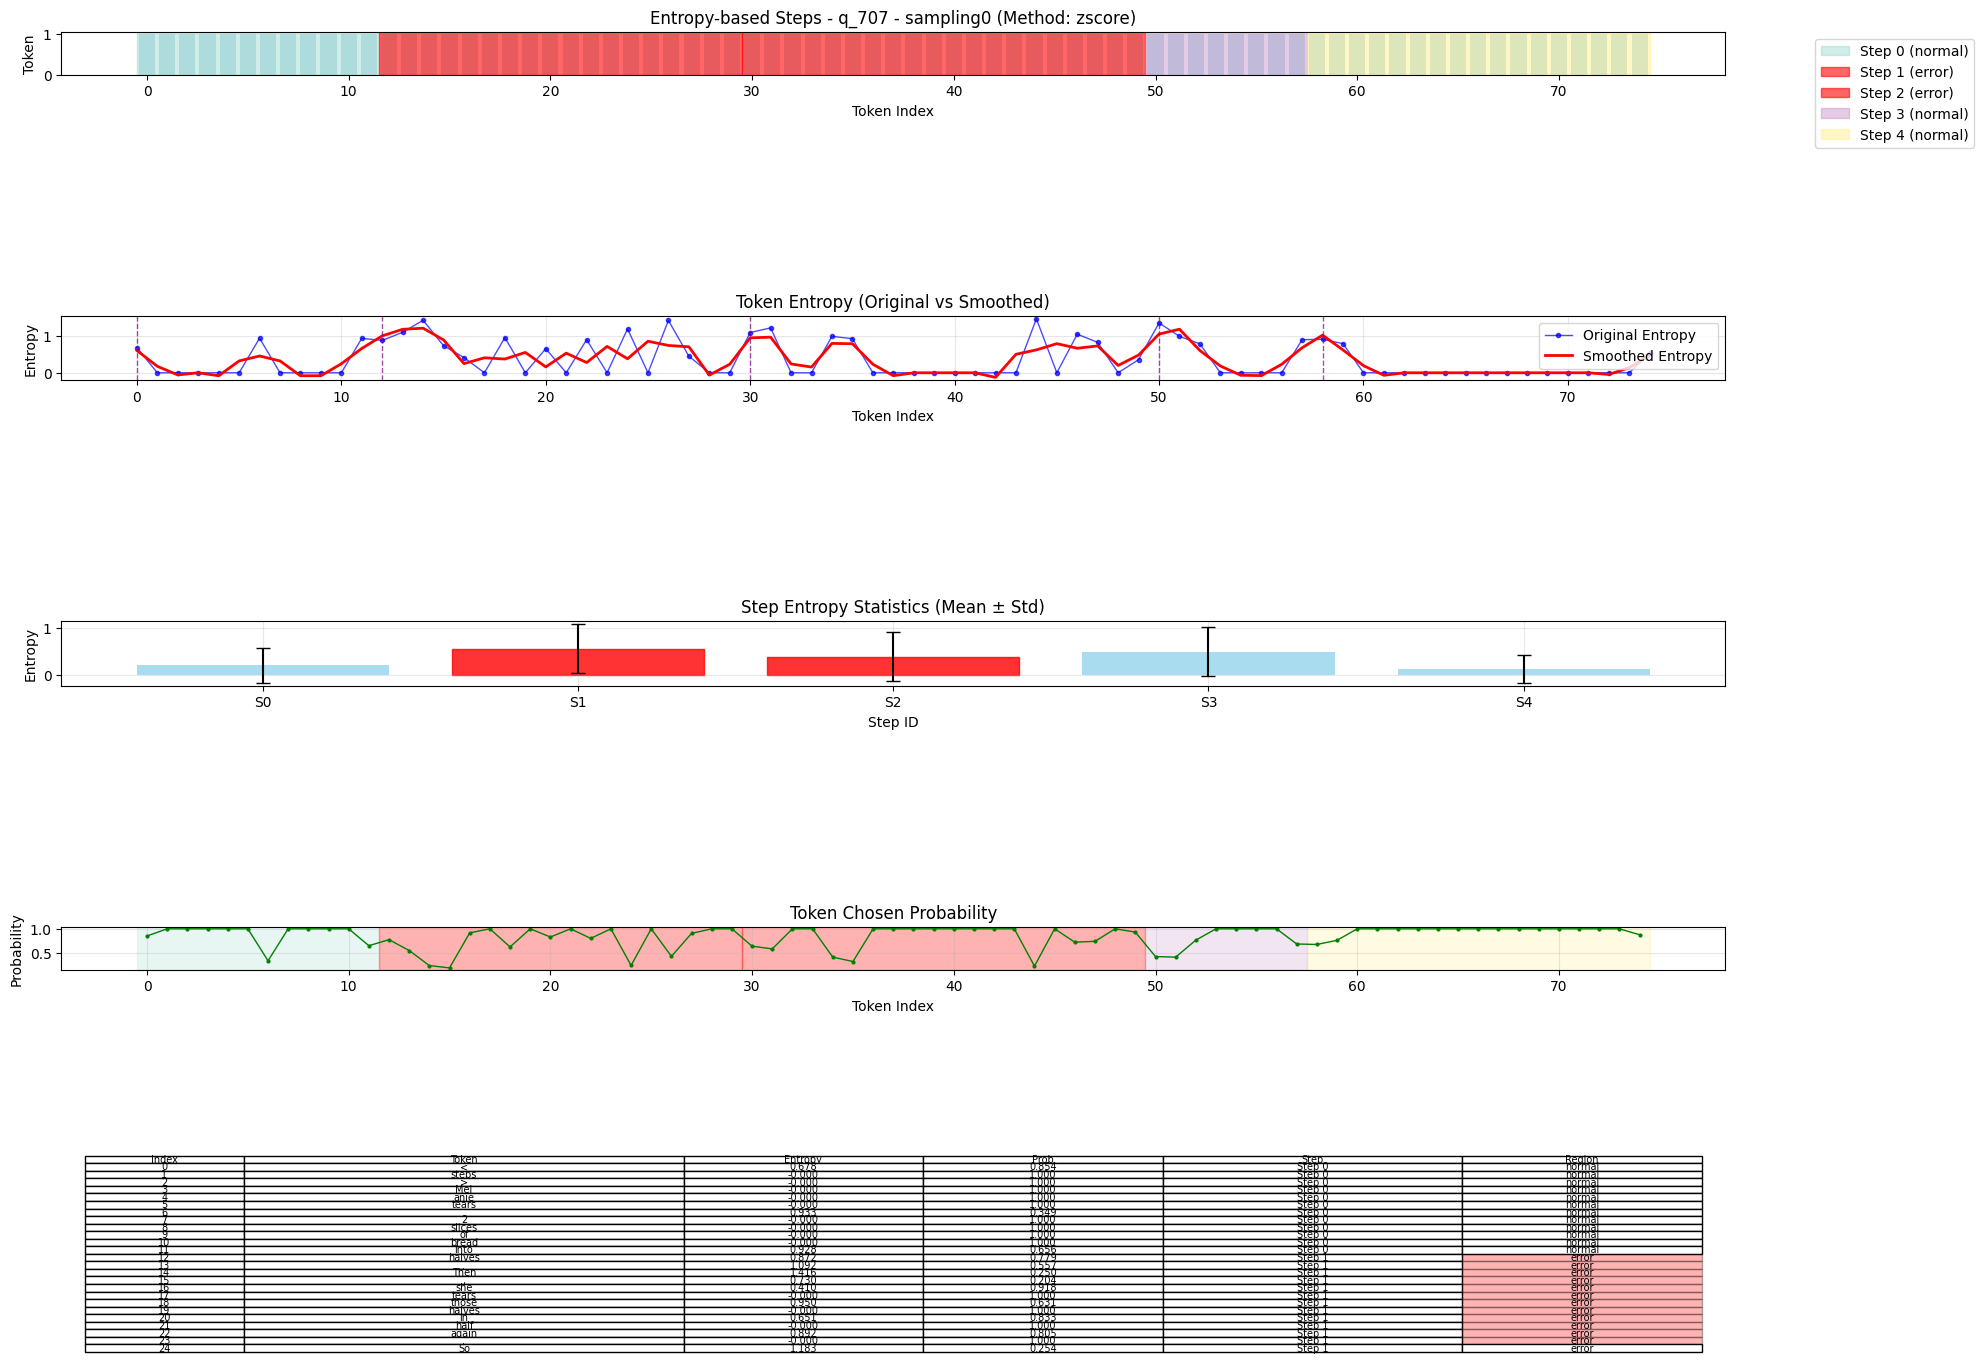


📊 ENTROPY-BASED STEP ANALYSIS: q_707 - sampling0
📋 Detection Method: zscore
📋 Sample Type: negative
📋 Total Steps: 5
📋 Total Tokens: 75
Step 0: Token 0--11
  Content: < steps > Mel anie tears  2 slices of bread into
  Entropy Mean: 0.212
  Entropy Std: 0.371
  Entropy Range: 0.933
  Token Count: 12

Step 1: Token 12--29 🔴 ERROR
  Content: halves . Then , she tears those halves in half again . So , each slice of bread
  Entropy Mean: 0.558
  Entropy Std: 0.514
  Entropy Range: 1.416
  Token Count: 18

Step 2: Token 30--49 🔴 ERROR
  Content: is torn into  2 *  2 =  4 pieces .  Mel anie is going to put
  Entropy Mean: 0.393
  Entropy Std: 0.517
  Entropy Range: 1.455
  Token Count: 20

Step 3: Token 50--57
  Content:  4 bread pieces into the blender .
  Entropy Mean: 0.500
  Entropy Std: 0.522
  Entropy Range: 1.344
  Token Count: 8

Step 4: Token 58--74
  Content:  </ steps >  < final _ result > 4 </ final _ result > <｜end▁of▁sentence｜>
  Entropy Mean: 0.131
  Entropy Std: 0.290
  Entro

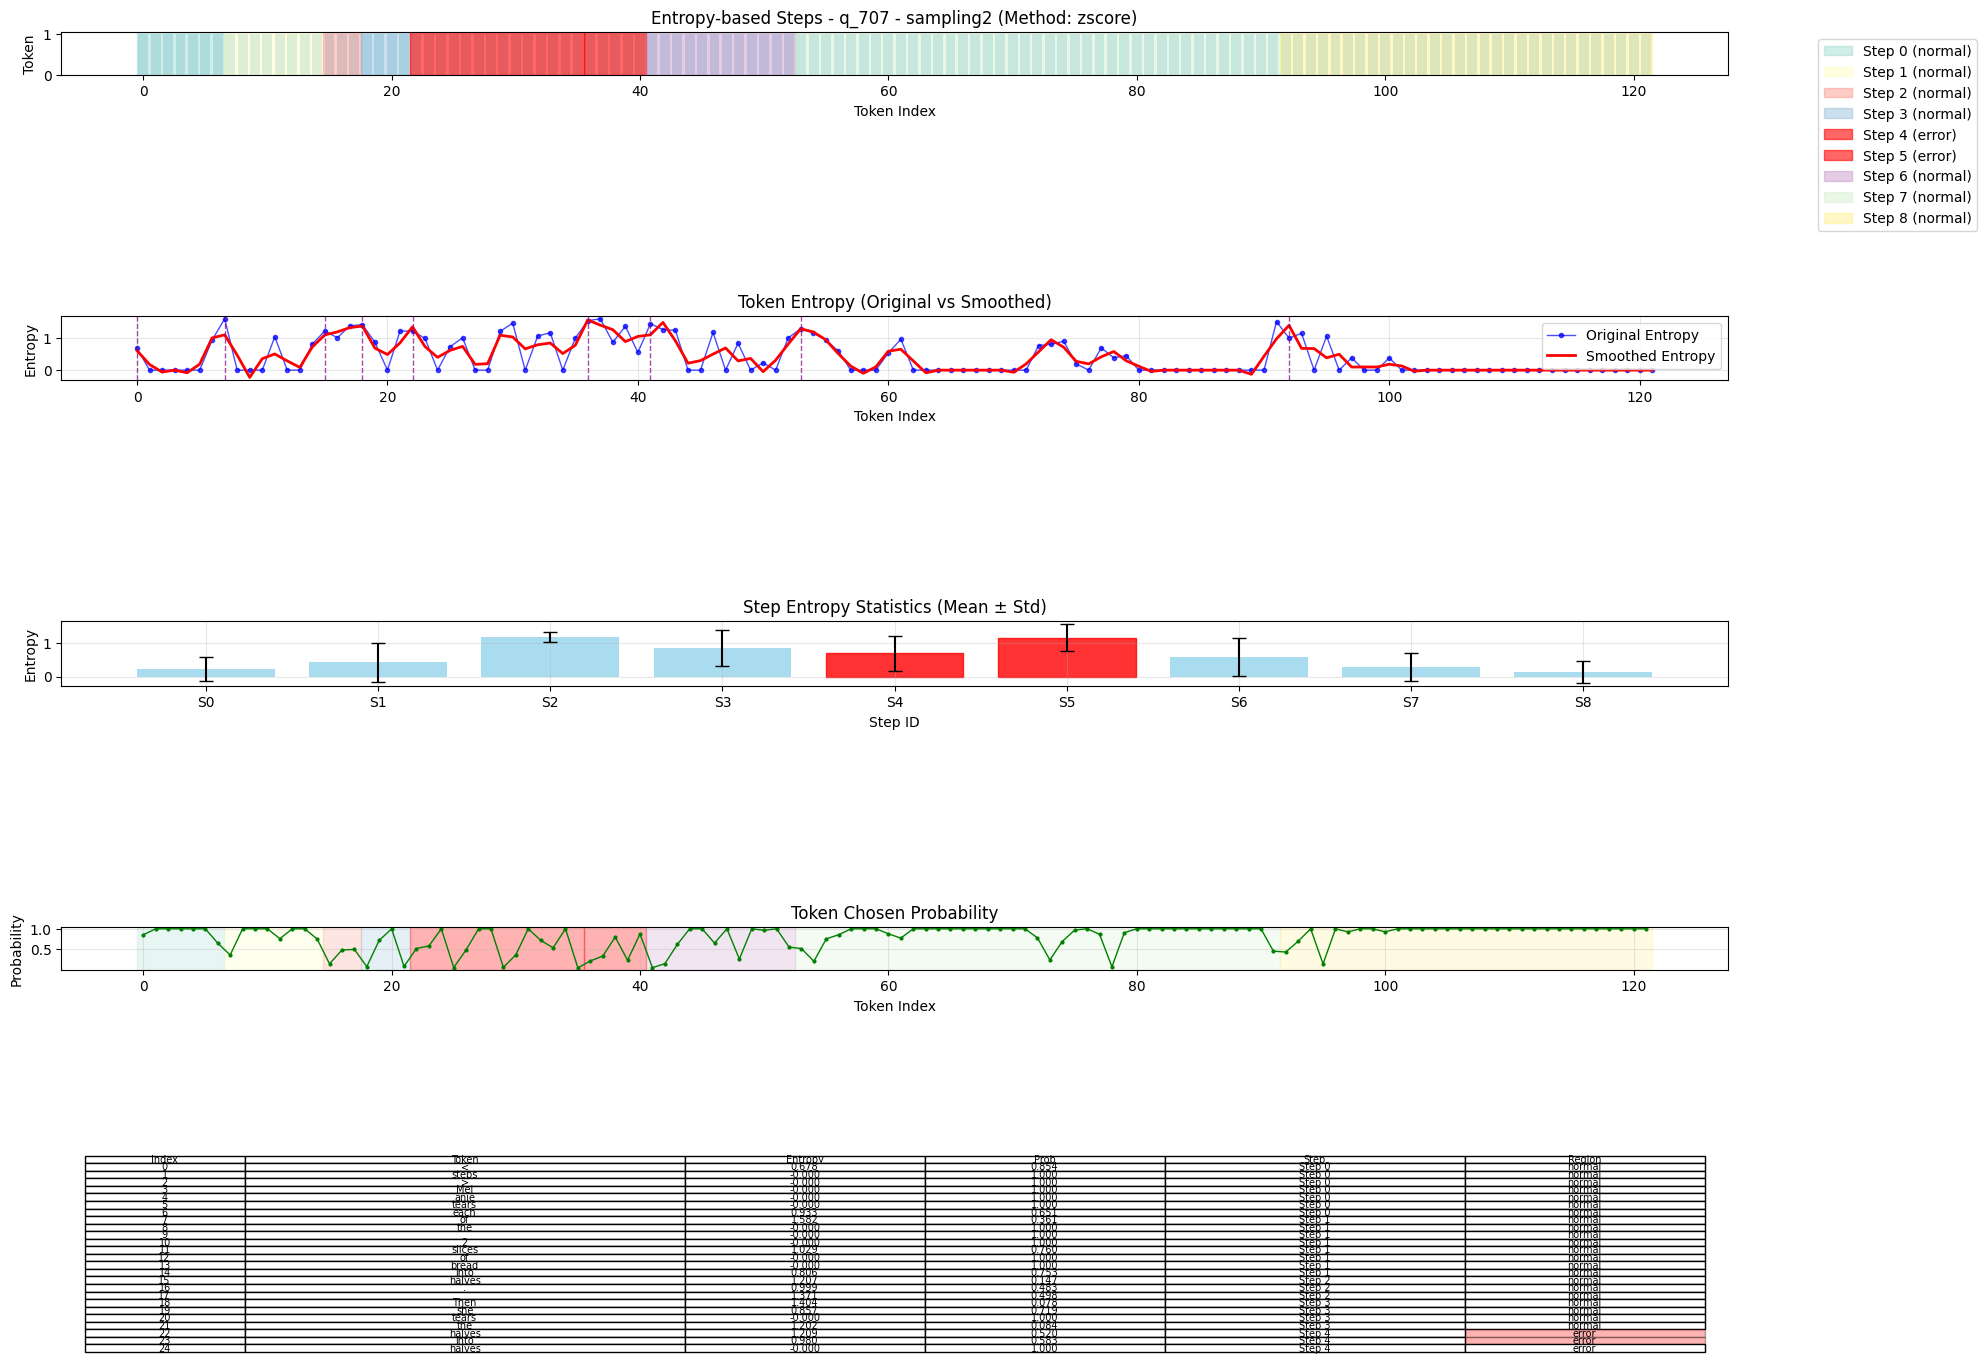


📊 ENTROPY-BASED STEP ANALYSIS: q_707 - sampling2
📋 Detection Method: zscore
📋 Sample Type: negative
📋 Total Steps: 9
📋 Total Tokens: 122
Step 0: Token 0--6
  Content: < steps > Mel anie tears each
  Entropy Mean: 0.230
  Entropy Std: 0.370
  Entropy Range: 0.933
  Token Count: 7

Step 1: Token 7--14
  Content: of the  2 slices of bread into
  Entropy Mean: 0.427
  Entropy Std: 0.587
  Entropy Range: 1.582
  Token Count: 8

Step 2: Token 15--17
  Content: halves . 
  Entropy Mean: 1.193
  Entropy Std: 0.152
  Entropy Range: 0.372
  Token Count: 3

Step 3: Token 18--21
  Content: Then she tears the
  Entropy Mean: 0.866
  Entropy Std: 0.537
  Entropy Range: 1.404
  Token Count: 4

Step 4: Token 22--35 🔴 ERROR
  Content: halves into halves once more .  The number of pieces of bread after
  Entropy Mean: 0.696
  Entropy Std: 0.541
  Entropy Range: 1.449
  Token Count: 14

Step 5: Token 36--40 🔴 ERROR
  Content: each step is : 
  Entropy Mean: 1.174
  Entropy Std: 0.405
  Entropy Range: 1.

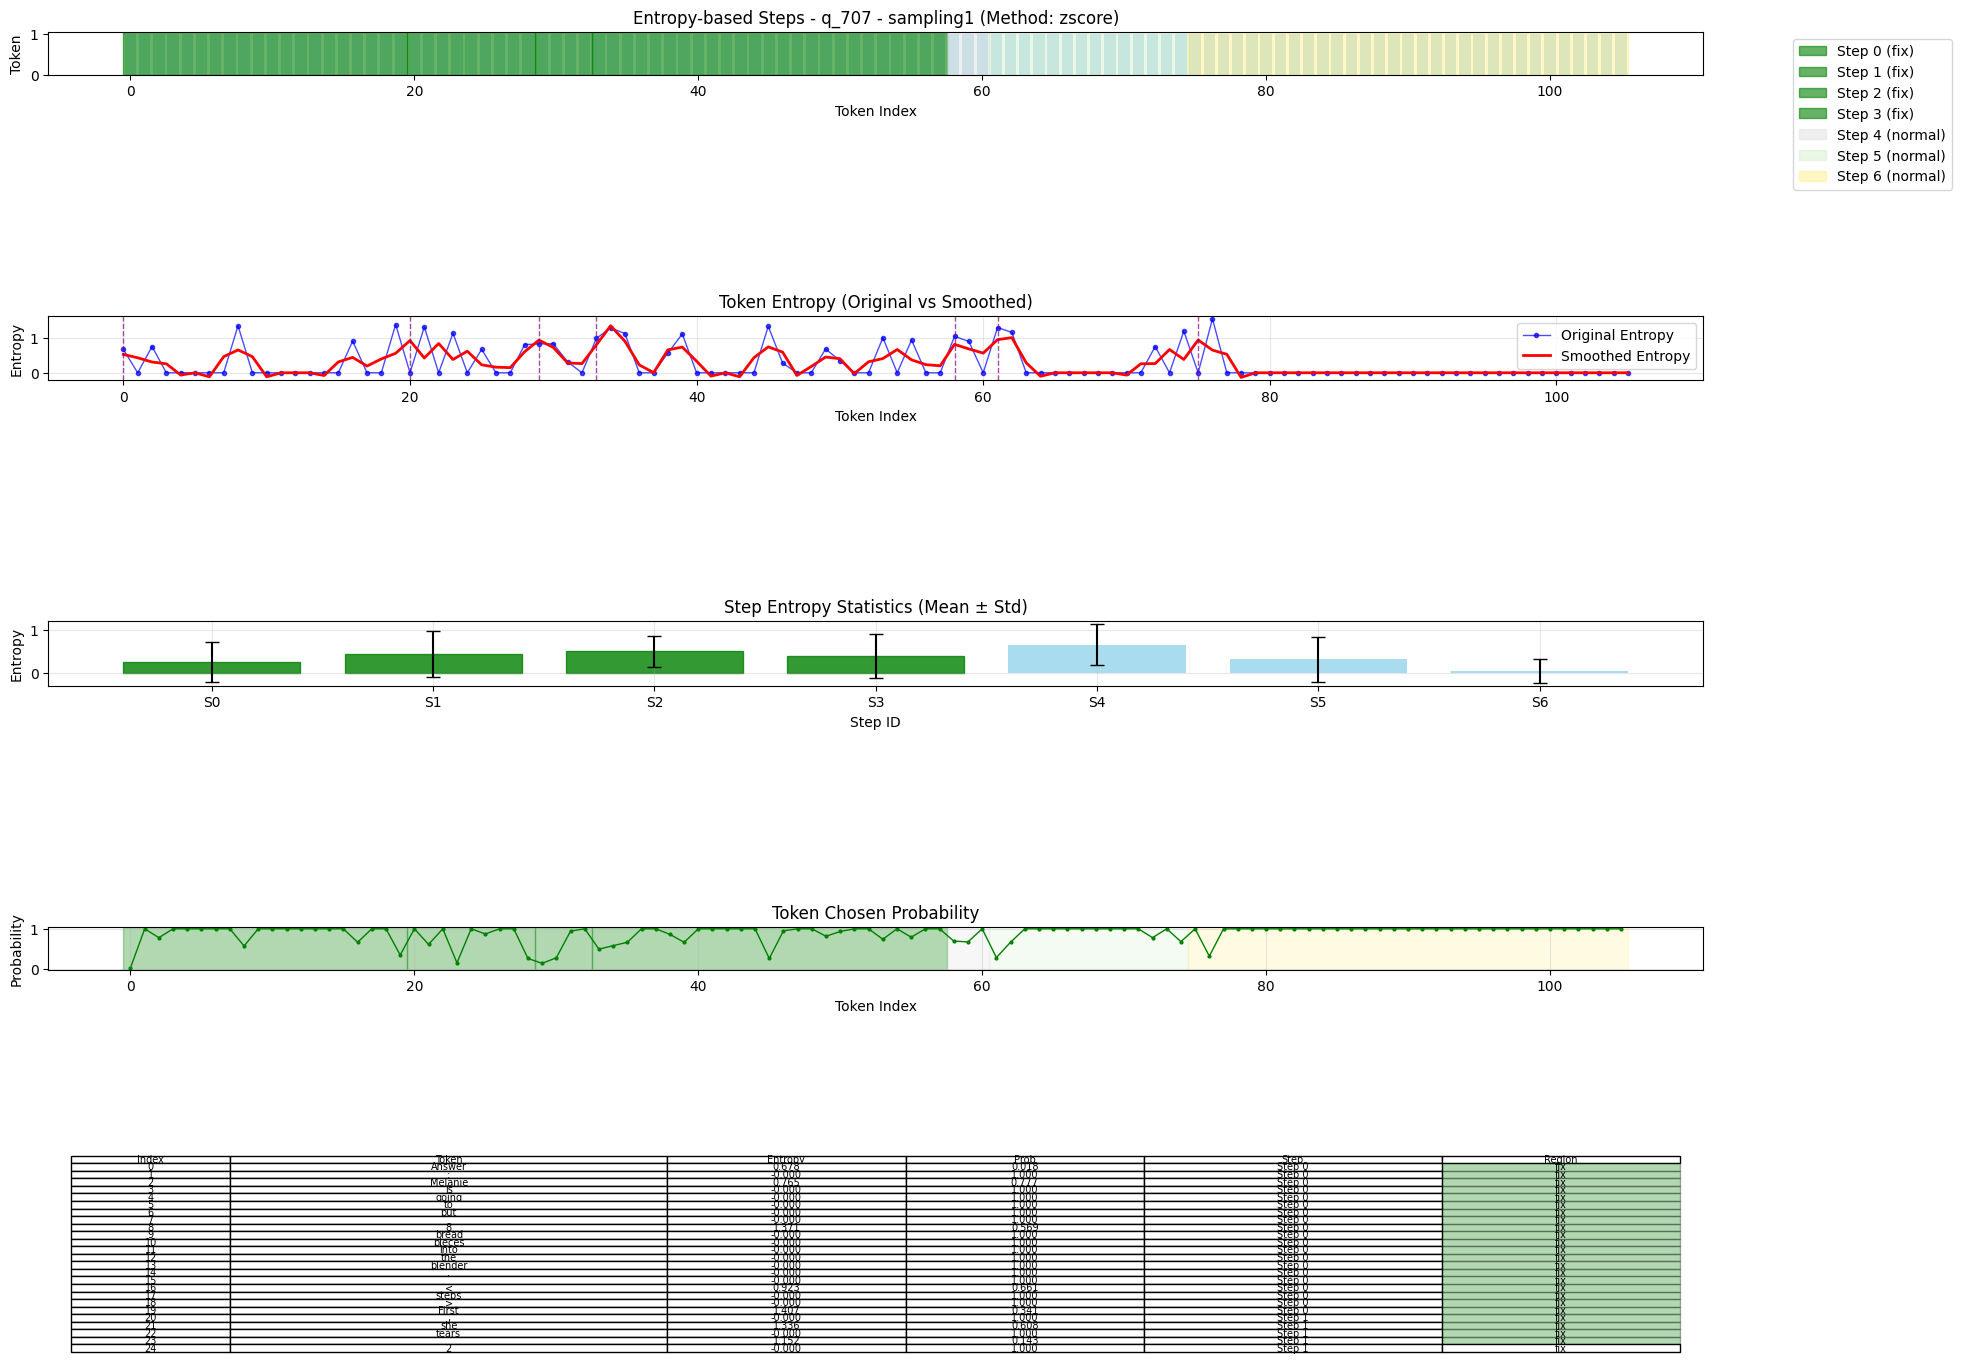


📊 ENTROPY-BASED STEP ANALYSIS: q_707 - sampling1
📋 Detection Method: zscore
📋 Sample Type: positive
📋 Total Steps: 7
📋 Total Tokens: 106
Step 0: Token 0--19 🟢 FIX
  Content: Answer : Melanie is going to put  8 bread pieces into the blender .  < steps > First
  Entropy Mean: 0.257
  Entropy Std: 0.471
  Entropy Range: 1.407
  Token Count: 20

Step 1: Token 20--28 🟢 FIX
  Content: , she tears  2 slices of bread into
  Entropy Mean: 0.443
  Entropy Std: 0.525
  Entropy Range: 1.336
  Token Count: 9

Step 2: Token 29--32 🟢 FIX
  Content:  2 halves each
  Entropy Mean: 0.501
  Entropy Std: 0.360
  Entropy Range: 0.845
  Token Count: 4

Step 3: Token 33--57 🟢 FIX
  Content: . This gives her  2 *  2 =  4 bread pieces .  Then , she tears each of those  4
  Entropy Mean: 0.393
  Entropy Std: 0.500
  Entropy Range: 1.353
  Token Count: 25

Step 4: Token 58--60
  Content: halves in half
  Entropy Mean: 0.658
  Entropy Std: 0.469
  Entropy Range: 1.061
  Token Count: 3

Step 5: Token 61--74
  Con

In [37]:

# =============================================================================
# 集成测试代码（需要在有数据的环境中运行）
# =============================================================================


# 在你的Colab环境中运行这些代码来测试entropy mapper

# 1. 创建entropy mapper实例
entropy_mapper = EntropyStepMapper(error_fix_data, original_data)
available_qids = list(error_fix_data.keys())
# 2. 测试单个样本的不同方法
test_qid = available_qids[4]
print(f"🧪 Testing different methods on {test_qid}")

# 比较所有方法
# comparison = entropy_mapper.compare_methods(test_qid)

# 3. 使用最佳方法处理样本
best_method = 'zscore'  # 根据比较结果选择
sample_data = entropy_mapper.process_sample_with_entropy(test_qid, method=best_method)

if sample_data:
    # 可视化结果
    for sampling_id in sample_data['samples'].keys():
        print(f"\\n📈 Visualizing {sampling_id} with {best_method} method...")
        entropy_mapper.visualize_entropy_steps(sample_data, sampling_id)


# # 4. 批量处理
# print("\\n🚀 Batch processing with entropy method...")
# entropy_results = entropy_mapper.batch_process_with_entropy(
#     available_qids[:3],
#     method=best_method,
#     max_samples=3
# )


# # 5. 导出结果
# if entropy_results:
#     save_path = f"{paths['save_path']}/entropy_analysis_results.json"
#     df = entropy_mapper.export_entropy_results(entropy_results, save_path)

#     print(f"\\n📊 Entropy analysis complete!")
#     print(f"📋 Processed {len(entropy_results)} samples")

#     # 对比原始方法和entropy方法的结果
#     if 'results' in globals():
#         print("\\n🔄 Comparing with similarity-based method...")

#         for qid in entropy_results.keys():
#             if qid in results:
#                 sim_steps = sum(len(s['step_token_mapping']) for s in results[qid]['samples'].values())
#                 ent_steps = sum(len(s['step_token_mapping']) for s in entropy_results[qid]['samples'].values())

#                 print(f"  {qid}: Similarity={sim_steps} steps, Entropy={ent_steps} steps")

# print("\\n🎉 Entropy-based step analysis complete!")
